In [122]:
__author__ = 'Nikola Djuza RA6-2012'

%matplotlib inline
import numpy as np
import sys
import cv2
import scipy as sc
import matplotlib.pyplot as plt

# pylab.rcParams['figure.figsize'] = 16, 12

from sklearn.cluster import KMeans
from midiutil.MidiFile import MIDIFile

In [123]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def display_image(image, color = False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def load_and_prepare_image(image_path):
    image = load_image(image_path)
    
    ret, image_bin = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

    return image_bin

In [124]:
def createFiveline(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    ys = list()
    minLineLength = 5
    maxLineGap = 30

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 70, minLineLength, maxLineGap)
        

    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (abs(y1 - y2 < 4)):
                cv2.line(image, (x1,y1), (x2,y2), (0, 255, 0), 2)
                innerlist = list()
                innerlist.append((y1 + y2) / 2)
                ys.append(innerlist)
    
    cv2.imwrite('images/houghlines.jpg', image)
    display_image(image)

    kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
    kmeans.fit(np.asarray(ys))

    fiveline = list()
    for innerlist in kmeans.cluster_centers_:
        fiveline.append(innerlist[0])

    fiveline.sort()
    return img

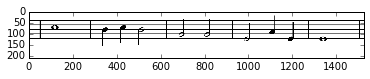

In [125]:
img = load_and_prepare_image('images/test.png')
img = cv2.imread('images/test.png');
plt.imshow(img, 'gray')

# fiveline = createFiveline(img)